In [2]:
import h5py
import numpy as np
import os
import pandas as pd
import subprocess
import time

from os import listdir
from os.path import isfile, join

import bacco
import baccoemu

import matplotlib
from matplotlib import pyplot as plt

2023-12-26 00:25:11.609398: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-26 00:25:13.736765: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-26 00:25:13.736919: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-26 00:25:14.040903: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-26 00:25:14.689760: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-26 00:25:14.697081: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [3]:
matplotlib.rcParams['ytick.labelsize'] = 16
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['axes.labelsize'] = 18
matplotlib.rcParams['legend.fontsize'] = 14
matplotlib.rcParams['axes.titlesize'] = 20

#matplotlib.rc('text', usetex=True)

## Bacco setup

In [4]:
##### DEFINE QUIJOTE COSMOLOGY ############
# The cosmology is not really needed but
# bacco P(k) corrects some modes according
# to their cosmology, so better have it
# just in case

a_Quijote = 1
Ob = 0.049
Om = 0.3175
hubble = 0.6711
ns = 0.9624
sigma8 = 0.834
cosmopars = dict(
        omega_cdm=Om-Ob,
        omega_baryon=Ob, 
        hubble=hubble, 
        ns=ns, 
        sigma8=sigma8,
        #tau=0.0561,
        A_s=None,
        neutrino_mass=0.,
        w0=-1,
        wa=0,
        tag="cosmo_BOSS"
    )
    
    
cosmo_Quijote = bacco.Cosmology(**cosmopars)
cosmo_Quijote.set_expfactor(a_Quijote)

2023-12-26 00:25:59,686 bacco.cosmo :    initialization took 0.000 secs


In [5]:
ngrid = 256 #1024 #512 #256 #128 #256 #1400
#nmean=0.01 not used
BoxSize=100/hubble
print(BoxSize)

bacco.configuration.update({'pknbody' : {'ngrid'  :  ngrid}})
bacco.configuration.update({'pknbody' : {'log_binning' : True}})
bacco.configuration.update({'pknbody' : {'log_binning_kmax' : 0.99506136}})#
bacco.configuration.update({'pknbody' : {'log_binning_nbins' : 100}})
bacco.configuration.update({'pknbody' : {'min_k' : 0.01721049}})
bacco.configuration.update({'pk' : {'maxk' : 0.99506136}}) 
bacco.configuration.update({'pknbody' : {'interlacing' : True}})

bacco.configuration.update({'pknbody' : {'depmethod' : 'cic'}})

bacco.configuration.update({'nonlinear' : {'concentration' : 'ludlow16'}})

bacco.configuration.update({'number_of_threads' : 12})
bacco.configuration.update({'scaling' : {'disp_ngrid' : ngrid}})

bacco.configuration.update({'pk':{'boltzmann_solver': 'CLASS'}})

149.0090895544628


## Load SAM data from hdf5 files

In [6]:
redshift = 0
dir_dat = '/lscratch/kstoreyf/CAMELS-SAM_data'

In [7]:
#fns_dat = [join(dir_dat, f) for f in listdir(dir_dat) if isfile(join(dir_dat, f))]
idx_sam = 0
fns_dat = [f'{dir_dat}/LH_{idx_sam}_galprops_z{redshift}.hdf5']

## Plot CAMELS SMFs

In [8]:
log_mass_shift = 9
h = 0.6711 # from perez et al
print(h**3)
vol_Mpc = (100/h)**3 # 100 Mpc/h = 100/h Mpc
vol_hMpc = 100**3 # units Mpc/h!! to match bgs; diff than plotted in camels paper
print(vol_Mpc, vol_hMpc)

0.302246803431
3308554.428527777 1000000


In [9]:
edges = np.linspace(8, 12.5, 40)

bin_width = edges[1] - edges[0]                
bins_avg = edges[0:-1] + bin_width/2.           

In [16]:
smf_arr = []
for fn_dat in fns_dat[:2]:
    with h5py.File(fn_dat, 'r') as f:
        mstar_raw = np.array(f['mstar'])
        log_mstar = np.log10(mstar_raw) + log_mass_shift
        
        phi, edges = np.histogram(log_mstar, bins=edges)   
        smf = phi / vol_Mpc / bin_width
        smf_arr.append(smf)    

<KeysViewHDF5 ['halo_index', 'mhalo', 'mstar', 'rhalo', 'sat_type', 'sfr', 'sfrave1gyr', 'vx', 'vy', 'vz', 'x_position', 'y_position', 'z_position']>
13


/tmp/ipykernel_240022/1568752271.py:7: RuntimeWarning: divide by zero encountered in log10
  log_mstar = np.log10(mstar_raw) + log_mass_shift


Text(0, 0.5, '$\\Phi \\: [\\mathrm{dex}^{-1}\\, \\mathrm{Mpc}^{-3}]$')

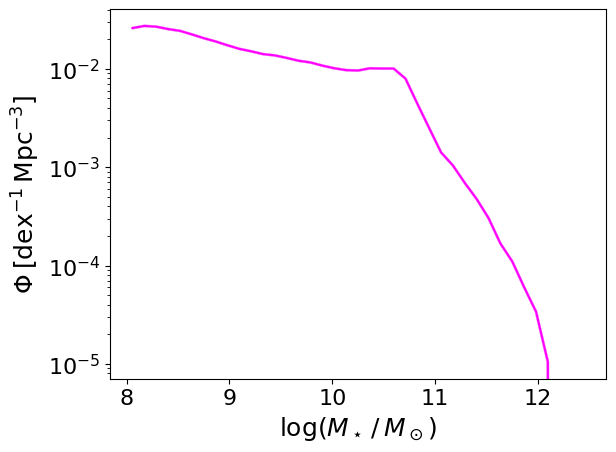

In [21]:
n_plot = 1
for i in range(n_plot):
    plt.plot(bins_avg, smf_arr[i], lw=0.2, color='navy')

smf_mean = np.mean(smf_arr, axis=0)
smf_std = np.std(smf_arr, axis=0)
plt.plot(bins_avg, smf_mean, color='magenta')
plt.fill_between(bins_avg, 
                 (smf_mean-smf_std), 
                 (smf_mean+smf_std),
                 color='magenta', alpha=0.3, lw=2,
                 label='pSMF all')
    
plt.yscale('log')
plt.xlabel(r'$\log(M_\star\,/\,M_\odot)$')
plt.ylabel(r'$\Phi \: [\mathrm{dex}^{-1}\, \mathrm{Mpc}^{-3}]$')

## Set up bacco P(k) code

In [22]:
args_power = {'ngrid':ngrid,
                  'box':BoxSize,
                  'cosmology':cosmo_Quijote,
                  'interlacing':True,
                  'kmin':0.1,
                  'kmax':1.0,
                  'nbins':30,
                  'correct_grid':True,
                  'log_binning':False,
                  'deposit_method':'cic',
                  'compute_correlation':False,
                  'zspace':False,
                  'normalise_grid': True,
                  'compute_power2d':False}

In [23]:
import logging
logger = logging.getLogger("bacco.power")
# only log really bad events
logger.setLevel(logging.ERROR)

In [24]:
pks = []
for fn_dat in fns_dat[:10]:
    with h5py.File(fn_dat, 'r') as f:
        x_arr, y_arr, z_arr = f['x_position'], f['y_position'], f['z_position']
        pos_arr = np.array([x_arr, y_arr, z_arr]).T
        pk = bacco.statistics.compute_powerspectrum(pos=pos_arr, **args_power)
        pks.append(pk)

2023-12-26 01:20:44,450 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=True
2023-12-26 01:20:45,084 bacco.cosmo :    computed CAMB power spectrum at z=0.00 in 0.235 secs
2023-12-26 01:20:45,090 bacco.cosmo :    created Pk(z=0) tab from k 7.450454722857103e-05 to 100000.0 h/Mpc
2023-12-26 01:20:45,165 bacco.cosmo :    computed halofit at z=0.00 for 'cosmo_BOSS' in 0.002 secs
2023-12-26 01:20:45,166 bacco.statistics :  setting the grid 256 True
2023-12-26 01:20:45,167 bacco.statistics : Computing cic mesh with ngrid=256 and interlacing=True
2023-12-26 01:20:45,169 bacco.statistics : starting deposit 1
2023-12-26 01:20:45,275 bacco.statistics :  mesh done in 0.108 s
2023-12-26 01:20:45,277 bacco.statistics :  Starting the power spectrum calculation
2023-12-26 01:20:45,513 bacco.statistics :  done compute.power
2023-12-26 01:20:45,515 bacco.statistics :  power done in 1.06 s


Text(0, 0.5, '$P(k)$')

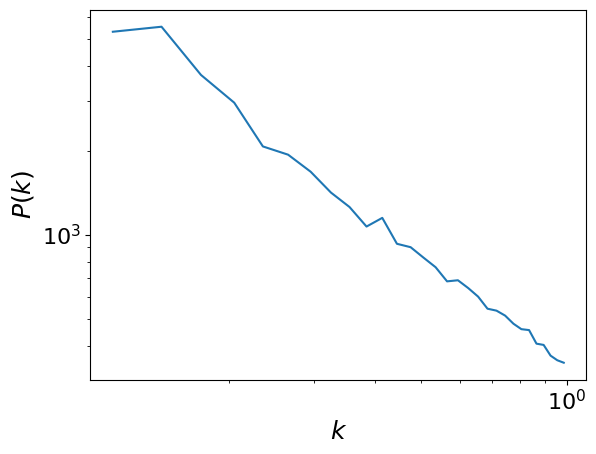

In [25]:
for i, fn_dat in enumerate(fns_dat[:10]):
    plt.plot(pks[i]['k'], pks[i]['pk'])
    
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$')
plt.ylabel(r'$P(k)$')

## Load bacco emu

In [74]:
emulator = baccoemu.Lbias_expansion()

  0% (0 of 12738560) |                   | Elapsed Time: 0:00:00 ETA:  --:--:--

Loading l-bias lpt emulator...


100% (12738560 of 12738560) |############| Elapsed Time: 0:00:00 Time:  0:00:00
/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: Inconsi

/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when u

L-bias lpt emulator loaded in memory.
Loading smeared bao emulator...


100% (1146880 of 1146880) |##############| Elapsed Time: 0:00:00 Time:  0:00:00
/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
  1% (442368 of 34867200) |              | Elapsed Time: 0:00:00 ETA:  00:00:00

Smeared bao emulator loaded in memory.
Loading non-linear l-bias emulator...


100% (34867200 of 34867200) |############| Elapsed Time: 0:00:00 Time:  0:00:00
/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.23.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
 10% (122880 of 1136640) |#              | Elapsed Time: 0:00:00 ETA:  00:00:00

Nonlinear l-bias emulator loaded in memory.
Loading sigma8 emulator...


100% (1136640 of 1136640) |##############| Elapsed Time: 0:00:00 Time:  0:00:00
  3% (270336 of 6922240) |               | Elapsed Time: 0:00:00 ETA:  00:00:00

Sigma8 emulator loaded in memory.
Loading no-wiggles emulator...


100% (6922240 of 6922240) |##############| Elapsed Time: 0:00:00 Time:  0:00:00


No-wiggles emulator loaded in memory.


/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [95]:
#k = np.logspace(-1.9, np.log10(emulator.emulator['nonlinear']['k'].max()), num=100)

In [82]:
# should this match camels??
params = {
    'omega_cold'    :  Om,
    'sigma8_cold'   :  sigma8, # if A_s is not specified
    'omega_baryon'  :  Ob,
    'ns'            :  ns,
    'hubble'        :  hubble,
    'neutrino_mass' :  0.0,
    'w0'            : -1.0,
    'wa'            :  0.0,
    'expfactor'     :  1
}

In [83]:
#k, pnn = emulator.get_nonlinear_pnn(k=k, **params)

### Fit bias params

In [ ]:
def ln_like(bias_params, k_data, p_data, C_inv):
    k, p_gg, p_gm = emulator.get_galaxy_real_pk(bias=bias_params, k=k_data, **params)
    delta_y = p_gm - p_gg
    lnlk = delta_y.T * C_inv * delta_y
    return lnlk

In [ ]:
k_data = # TODO
p_data = pks[0]
C_inv = np.diag(np.ones(len(pk_data))/len(pk_data))

In [ ]:
bias_params_0 = [0.5, 0.5, 1.0, -1.0]
bias_params = scipy.optimize.minimize(ln_like, bias_params_0, args=[k_data, p_data, C_inv])